In [1]:
import torch
import numpy as np
import kornia
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import ToTensor


In [2]:

def load_image_kornia(path):
    # read BGR
    img = cv2.imread(path)  
    # convert to RGB *and* copy so strides are positive
    img_rgb = img[:, :, ::-1].copy()  
    # build tensor manually (avoiding ToTensor), normalize to [0,1]
    img_tensor = torch.from_numpy(img_rgb) \
                       .permute(2, 0, 1) \
                       .unsqueeze(0) \
                       .float() / 255.0  # shape (1,3,H,W)
    return img_tensor


In [3]:

def extract_y(img_tensor):
    ycbcr = kornia.color.rgb_to_ycbcr(img_tensor)
    return ycbcr[:, 0:1, :, :]  # (B, 1, H, W)


In [4]:
def compute_fft_kornia(y_tensor):
    y = y_tensor.squeeze(1)  # (B, H, W)
    fft = torch.fft.fft2(y)
    fft_shifted = torch.fft.fftshift(fft, dim=(-2, -1))
    magnitude = torch.abs(fft_shifted)
    log_mag = torch.log1p(magnitude)
    return log_mag


In [5]:

def plot_fft_comparison(img_path,save_path=None):
    img_tensor = load_image_kornia(img_path)
    y_tensor = extract_y(img_tensor)
    fft_mag = compute_fft_kornia(y_tensor)

    img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
    fft_np = fft_mag.squeeze().numpy()

    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    #plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(fft_np, cmap='gray')
    #plt.title("FFT of Y Channel (log scale)")
    plt.axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [6]:

def plot_fft(img_path,title,save_path=None):
    img_tensor = load_image_kornia(img_path)
    y_tensor = extract_y(img_tensor)
    fft_mag = compute_fft_kornia(y_tensor)

    
    fft_np = fft_mag.squeeze().numpy()


    plt.figure(figsize=(6, 6))
    plt.imshow(fft_np, cmap='gray')
    plt.title(title)
    plt.xlabel("Frequency (u)")
    plt.ylabel("Frequency (v)")
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [9]:
def plot_fft(img_path, title, dx=0.0065, dy=0.0065, save_path=None):
    """
    Plot FFT (log-magnitude) of the Y channel with axes in physical spatial frequency.
    dx, dy: pixel pitch in millimeters (columns, rows).
    """
    # Load + Y channel
    img_tensor = load_image_kornia(img_path)
    y_tensor = extract_y(img_tensor)                 # (1,1,H,W)

    # FFT (you already return log(1+|FFT|))
    fft_log = compute_fft_kornia(y_tensor).squeeze().cpu().numpy()  # (H,W)

    # Frequency axes in cycles/mm
    H, W = fft_log.shape
    fy = np.fft.fftshift(np.fft.fftfreq(H, d=dy))    # vertical frequency (cycles/mm)
    fx = np.fft.fftshift(np.fft.fftfreq(W, d=dx))    # horizontal frequency (cycles/mm)

    # Plot with correct physical extent
    plt.figure(figsize=(6, 6))
    plt.imshow(
        fft_log,
        cmap='gray',
        extent=[fx[0], fx[-1], fy[0], fy[-1]],   # map pixels → cycles/mm
        origin='lower',
        aspect='equal'
    )
    plt.title(title if title else "FFT of Y Channel (log scale)")
    plt.xlabel(r'$f_x$ (cycles/mm)')
    plt.ylabel(r'$f_y$ (cycles/mm)')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


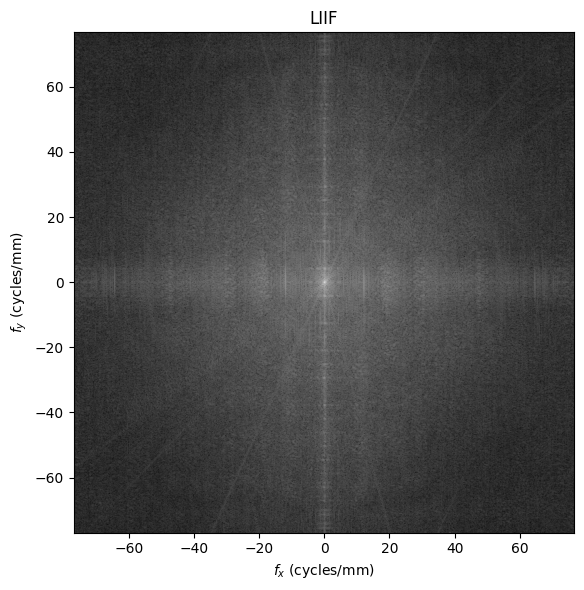

In [25]:
title = 'LIIF'
img_path = 'test_imgs/SR/liif/pc.png'
save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/only_fft/pie_chart/liif.png'
plot_fft(img_path,title=title ,save_path=save_path)

In [28]:
#plot_fft_comparison('test_imgs/SR/edsr/bc2.png',save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/comparison_plots_fft/FFT_edsr_bc2.png')
#plot_fft_comparison('test_imgs/HR/bar_chart_20250519_081655_ec01b7db.png',save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/comparison_plots_fft/FFT_gt_bc2.png')

In [29]:
def compute_raw_fft_magnitude(y_tensor: torch.Tensor) -> np.ndarray:
    y = y_tensor.squeeze(1)  # (1, H, W)
    fft = torch.fft.fft2(y)
    fft = torch.fft.fftshift(fft, dim=(-2, -1))
    mag = torch.abs(fft)
    return mag.squeeze().cpu().numpy()

In [30]:
def radial_profile(data: np.ndarray, num_bins: int = 100):
    h, w = data.shape
    cy, cx = h//2, w//2
    Y, X = np.indices((h, w))
    R = np.sqrt((X - cx)**2 + (Y - cy)**2).ravel()
    V = data.ravel()
    bins = np.linspace(0, R.max(), num_bins+1)
    inds = np.digitize(R, bins)
    prof = np.array([
        V[inds == i].mean() if np.any(inds == i) else np.nan
        for i in range(1, len(bins))
    ])
    # bin centers in pixels:
    bin_centers = (bins[:-1] + bins[1:]) * 0.5
    return bin_centers, prof

In [31]:
def plot_power_spectrum(gt_path, sr_path,save_path=None):
    gt_tensor = load_image_kornia(gt_path)
    sr_tensor = load_image_kornia(sr_path)
    gt_y = extract_y(gt_tensor)
    sr_y = extract_y(sr_tensor)
    magnitude_gt = compute_raw_fft_magnitude(gt_y)
    magnitude_sr = compute_raw_fft_magnitude(sr_y)
    power_gt = magnitude_gt ** 2
    power_sr = magnitude_sr ** 2
    rad_px, power_gt_px = radial_profile(power_gt, num_bins=150)
    _, power_sr_px = radial_profile(power_sr, num_bins=150)
    W = magnitude_gt.shape[1]           
    freq = rad_px / W              
    mask = freq > 0                
    freq = freq[mask]
    
    power_gt_f = power_gt_px[mask]
    power_sr_f = power_sr_px[mask]
    amp_gt_f = np.sqrt(power_gt_f)
    amp_sr_f = np.sqrt(power_sr_f)
    
    plt.figure(figsize=(8,6),dpi=128)
    plt.loglog(freq, power_gt_f, label='GT',linewidth=2)
    plt.loglog(freq, power_sr_f, label='SR',linewidth=2, alpha=0.8)
    plt.xlabel('Spatial Frequency')
    plt.ylabel('Power')
    plt.title('Radial Power Spectrum')
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path,dpi=128)
    plt.show()

    #plt.figure(figsize=(12,6),dpi=150)
    #plt.loglog(freq, amp_gt_f, label='GT Amplitude',linewidth=2)
    #plt.loglog(freq, amp_sr_f, label='SR Amplitude',linewidth=2, alpha=0.8)
    #plt.xlabel('Spatial Frequency (cycles/pixel)')
    #plt.ylabel('Amplitude')
    #plt.title('Radial Amplitude Spectrum')
    #plt.legend()
    #plt.grid(True, which='both', ls='--', lw=0.5)
    #plt.tight_layout()
    #plt.show()
    
    


In [39]:
def plot_power_spectrum_multi(gt_path, sr_path, save_path=None):
    import os

    # --- GT once ---
    gt_tensor = load_image_kornia(gt_path)
    gt_y = extract_y(gt_tensor)
    magnitude_gt = compute_raw_fft_magnitude(gt_y)
    power_gt = magnitude_gt ** 2
    rad_px, power_gt_px = radial_profile(power_gt, num_bins=150)
    W = magnitude_gt.shape[1]
    freq = rad_px / W
    mask = freq > 0
    freq = freq[mask]
    power_gt_f = power_gt_px[mask]

    # --- Normalize sr_path into iterable of (label, path) ---
    if isinstance(sr_path, str):
        sr_items = [("SR", sr_path)]
    elif isinstance(sr_path, dict):
        sr_items = list(sr_path.items())
    else:  # list/tuple of paths
        sr_items = []
        for p in sr_path:
            # auto-label from filename
            lbl = os.path.splitext(os.path.basename(p))[0] or "SR"
            sr_items.append((lbl, p))

    # --- Plot ---
    plt.figure(figsize=(8, 6), dpi=128)
    plt.loglog(freq,power_gt_f,label='Ground Truth',linewidth=3,color='black',linestyle='-',)

    for label, path in sr_items:
        sr_tensor = load_image_kornia(path)
        sr_y = extract_y(sr_tensor)
        magnitude_sr = compute_raw_fft_magnitude(sr_y)
        power_sr = magnitude_sr ** 2
        _, power_sr_px = radial_profile(power_sr, num_bins=150)
        power_sr_f = power_sr_px[mask]
        plt.loglog(freq, power_sr_f, label=label, linewidth=1, alpha=0.9)

    plt.xlabel('Spatial Frequency')  # cycles/pixel by construction
    plt.ylabel('Power')
    plt.title('Radial Power Spectrum')
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=128)
    plt.show()


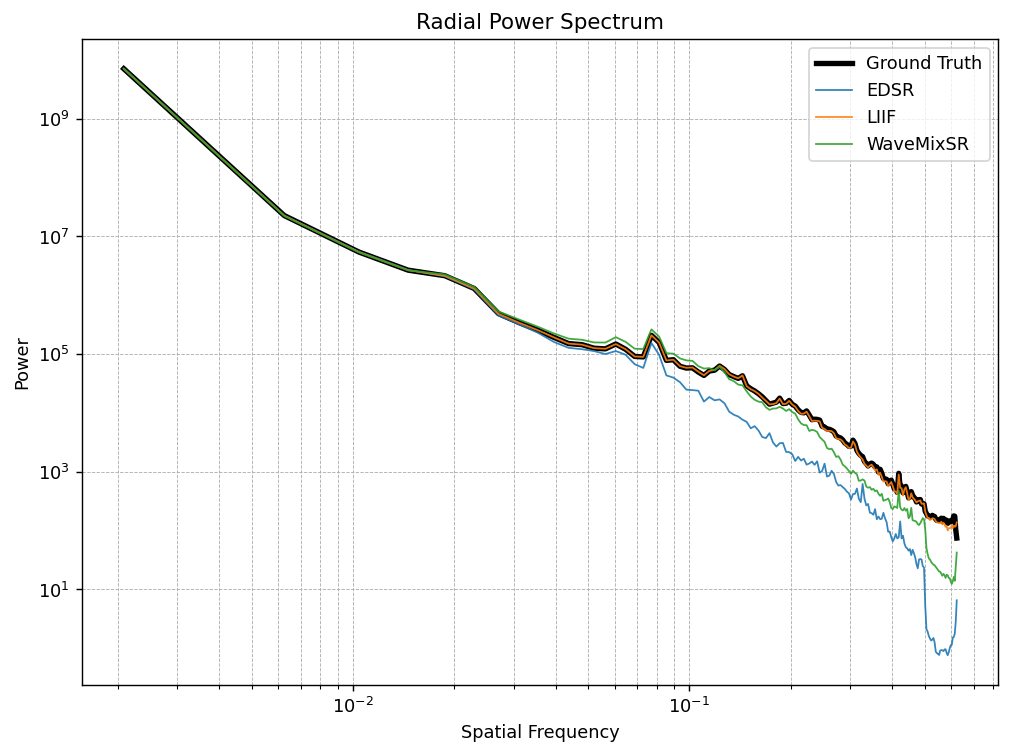

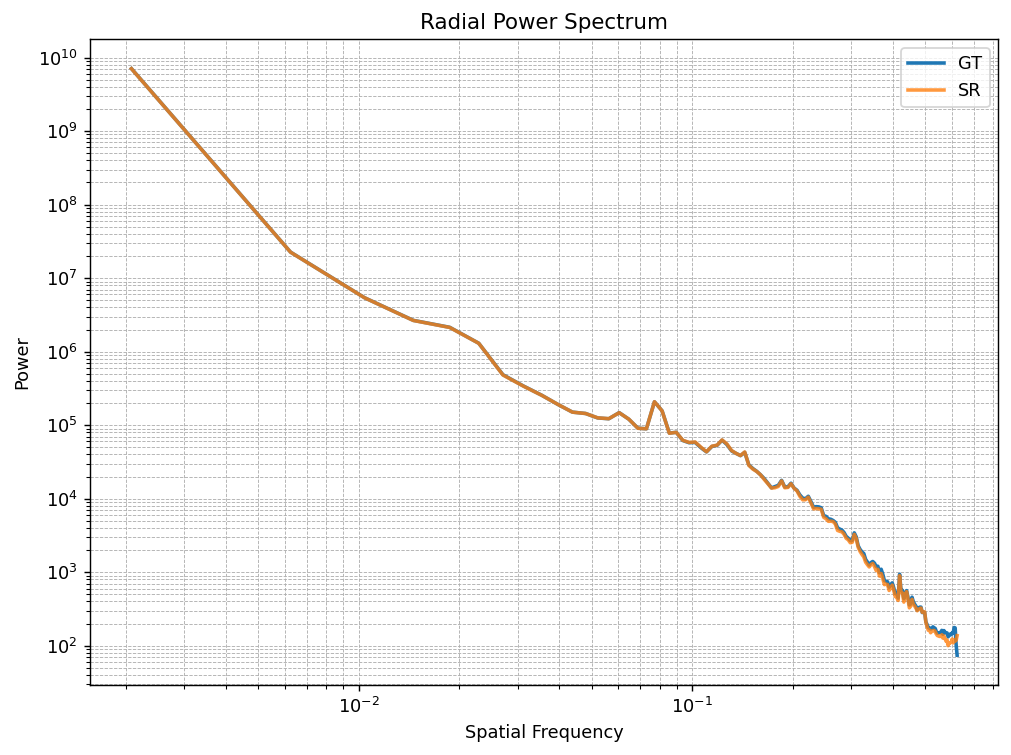

In [40]:
gt_path = 'test_imgs/HR/pie_chart_20250519_081946_9afe32b4.png'
sr_path = 'test_imgs/SR/liif/pc.png'

sr_edsr_path = 'test_imgs/SR/edsr/pc.png'
sr_liif_path = 'test_imgs/SR/liif/pc.png'
sr_wavemixsr_path = 'test_imgs/SR/wavemixsr/pc.png'
plot_power_spectrum_multi(gt_path, {"EDSR": sr_edsr_path, "LIIF": sr_liif_path, "WaveMixSR": sr_wavemixsr_path},save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/comparison_plots_fft/power_spectrum_multi.png')
plot_power_spectrum(gt_path, sr_path, save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/comparison_plots_fft/liif/pp/power_spectrum_liif_pc.png')

In [22]:
gt_path = 'test_imgs/HR/bar_chart_20250519_081655_ec01b7db.png'
sr_path = 'test_imgs/SR/sr_image_edsr.png'

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

def plot_radial_power_spectrum_matched(gt_path, sr_path, num_bins=150, panel_height=6, save_path=None):
    """
    Plot only the radial power spectrum (GT vs SR) in a single panel whose
    figure aspect matches your SR‐image and SR‐FFT panels.

    panel_height: desired figure height in inches (e.g. 6)
    panel_width is computed to be panel_height * (w_img/h_img)
    """
    # 1) Load & extract Y channel
    sr_t = load_image_kornia(sr_path)      # (1,3,H,W)
    gt_t = load_image_kornia(gt_path)
    sr_y = extract_y(sr_t)         # (1,1,H,W)
    gt_y = extract_y(gt_t)

    # 2) Compute power spectra
    mag_sr = compute_raw_fft_magnitude(sr_y)
    mag_gt = compute_raw_fft_magnitude(gt_y)
    p_sr = mag_sr**2
    p_gt = mag_gt**2

    # 3) Radial profiles
    freqs, prof_sr = radial_profile(p_sr, num_bins=num_bins)
    _,     prof_gt = radial_profile(p_gt, num_bins=num_bins)

    # 4) Determine SR image aspect (width/height)
    sr_img = sr_t.squeeze(0).permute(1,2,0).cpu().numpy()
    h_img, w_img = sr_img.shape[:2]
    aspect = w_img / h_img

    # 5) Compute figure size to match that aspect
    fig_w = panel_height * aspect
    fig_h = panel_height

    # 6) Make the figure and plot
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=600)
    ax.loglog(freqs, prof_gt, label='GT Power', linewidth=2)
    ax.loglog(freqs, prof_sr, label='SR Power', linewidth=2, alpha=0.8)
    ax.set_xlabel('Spatial Frequency')
    ax.set_ylabel('Power')
    ax.grid(True, which='both', ls='--', lw=0.5, alpha=0.6)
    ax.legend()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


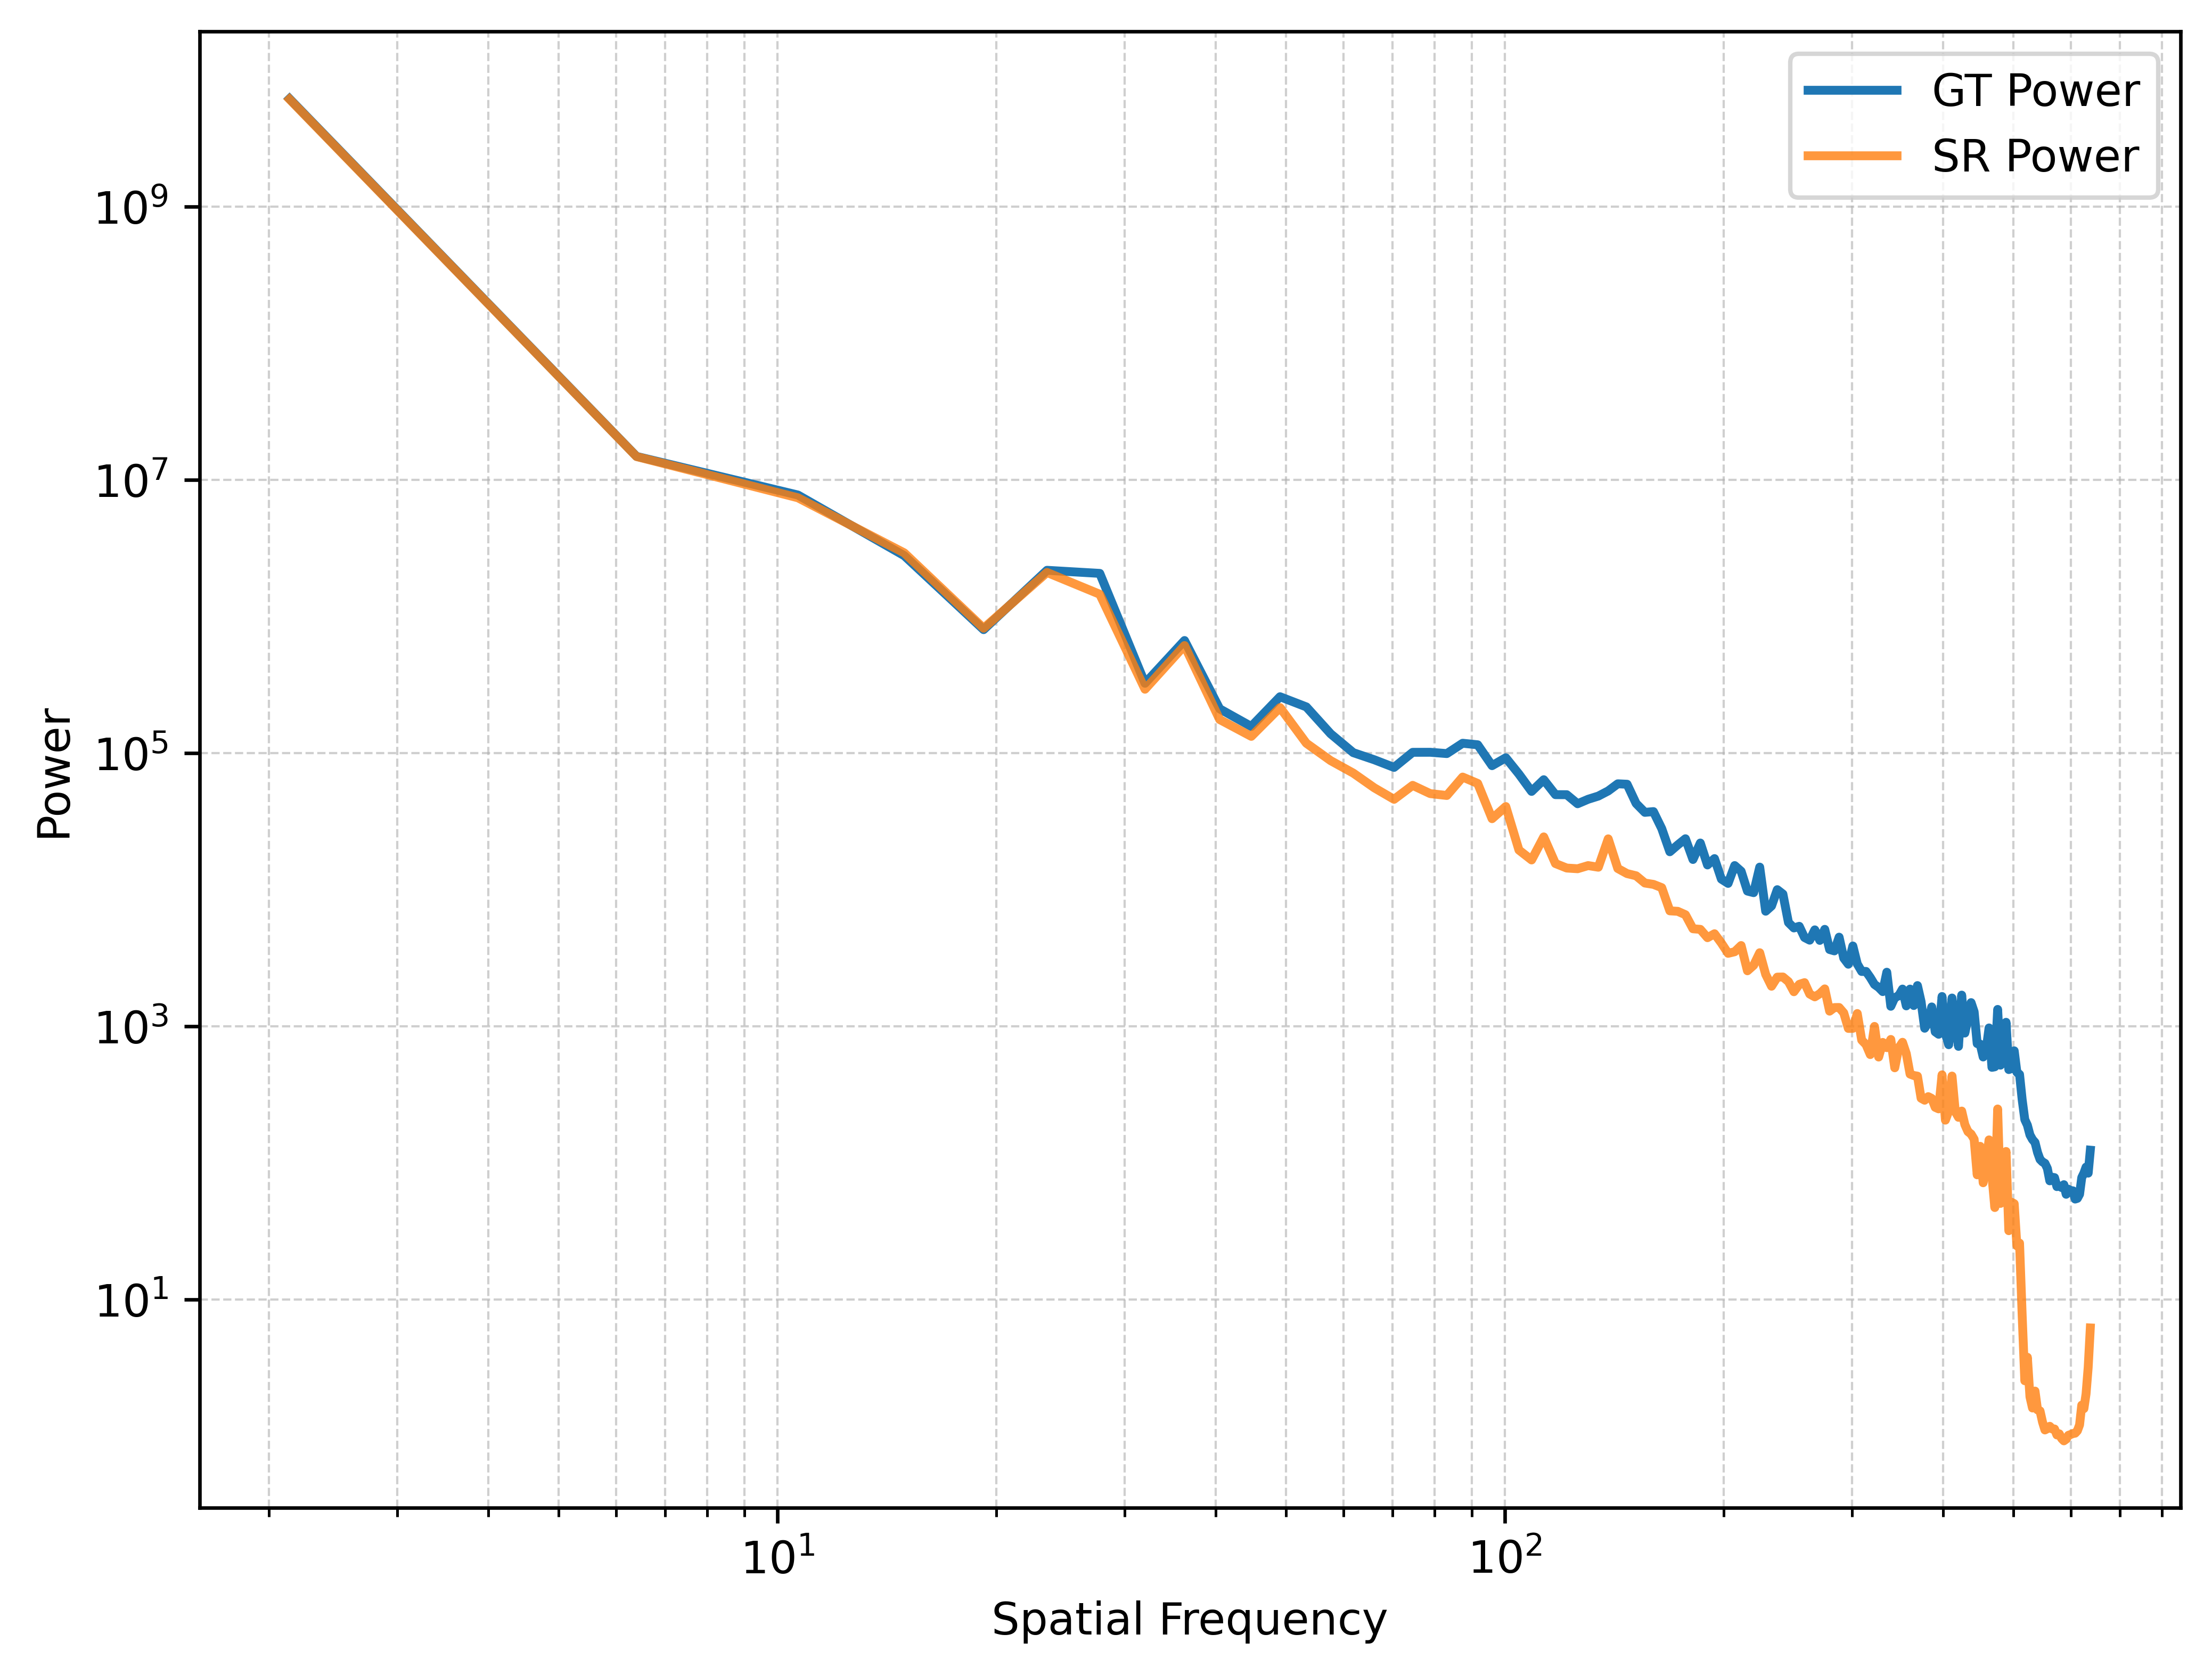

In [24]:
plot_radial_power_spectrum_matched(gt_path, sr_path, save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/FFT/power_plot.pdf')

In [14]:
def plot_spikes(gt_path, sr_path, save_path=None):

    gt_tensor = load_image_kornia(gt_path)      # (1,3,H,W)
    sr_tensor = load_image_kornia(sr_path)
    gt_y = extract_y(gt_tensor)         # (1,1,H,W)
    sr_y = extract_y(sr_tensor)

    # --- 2D FFT and shift to center ---
    fft_gt = torch.fft.fft2(gt_y)
    fft_sr = torch.fft.fft2(sr_y)
    fft_shifted_gt = torch.fft.fftshift(fft_gt, dim=(-2, -1))
    fft_shifted_sr = torch.fft.fftshift(fft_sr, dim=(-2, -1))

    # --- Convert to numpy and squeeze to 2D ---
    fft2d_gt = fft_shifted_gt.cpu().numpy().squeeze()
    fft2d_sr = fft_shifted_sr.cpu().numpy().squeeze()

    # --- Take the central row of each FFT and compute power ---
    h, w = fft2d_gt.shape
    row_gt = fft2d_gt[h//2, :]
    row_sr = fft2d_sr[h//2, :]
    power_gt = np.abs(row_gt)**2
    power_sr = np.abs(row_sr)**2

    # --- Build spatial‐frequency axis (cycles/pixel) ---
    freqs = np.fft.fftfreq(w, d=1.0)      # cycles/pixel
    freqs = np.fft.fftshift(freqs)
    power_gt = np.fft.fftshift(power_gt)
    power_sr = np.fft.fftshift(power_sr)

    # --- Only plot positive freqs (0 to Nyquist) ---
    pos = freqs > 0
    f_pos = freqs[pos]
    p_gt_pos = power_gt[pos]
    p_sr_pos = power_sr[pos]

    plt.figure(figsize=(10, 4), dpi=150)
    plt.semilogy(f_pos, p_gt_pos, linewidth=2, label='GT Power')
    plt.semilogy(f_pos, p_sr_pos, linewidth=2, alpha=0.8, label='SR Power')
    plt.xlabel('Spatial Frequency (cycles/pixel)', fontsize=12)
    plt.ylabel('Power (log scale)', fontsize=12)
    plt.title('1D Power Spectrum (Central-Row Slice)', fontsize=14)
    plt.grid(True, which='both', ls='--', lw=0.5, alpha=0.6)
    plt.legend(fontsize=11)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


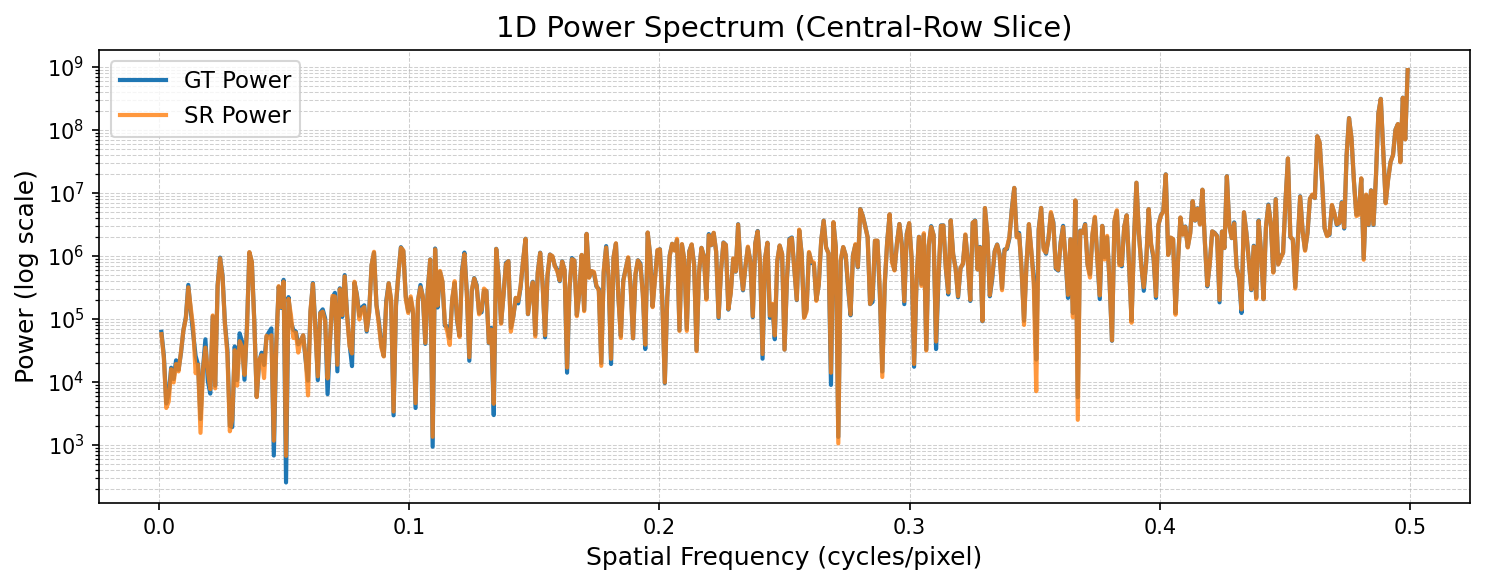

In [15]:
plot_spikes(gt_path, sr_path, save_path='C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/OCR_metric/test_imgs/FFT/spikes_plot.png')

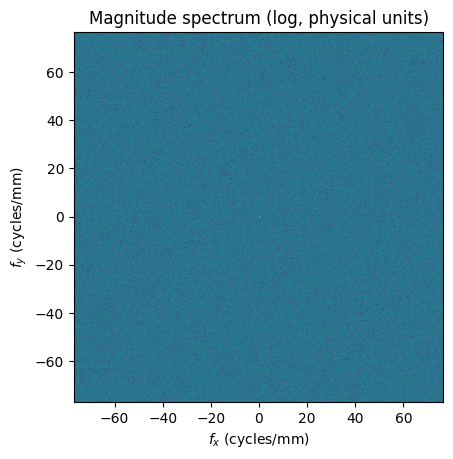

In [1]:
import numpy as np
import matplotlib.pyplot as plt

img = np.random.rand(512, 512)

# Known pixel spacing (pitch) in mm:
dy = 0.0065   # row spacing (along y)
dx = 0.0065   # column spacing (along x)

F = np.fft.fft2(img)
Fshift = np.fft.fftshift(F)
mag = np.abs(Fshift)

M, N = img.shape
fy = np.fft.fftshift(np.fft.fftfreq(M, d=dy))  # cycles/mm vertically
fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx))  # cycles/mm horizontally

plt.imshow(np.log1p(mag), extent=[fx[0], fx[-1], fy[0], fy[-1]], origin='lower')
plt.xlabel(r'$f_x$ (cycles/mm)')
plt.ylabel(r'$f_y$ (cycles/mm)')
plt.title('Magnitude spectrum (log, physical units)')
plt.show()